# Visualizando la participación de cada personaje en el guión (gráficos hechos en R)

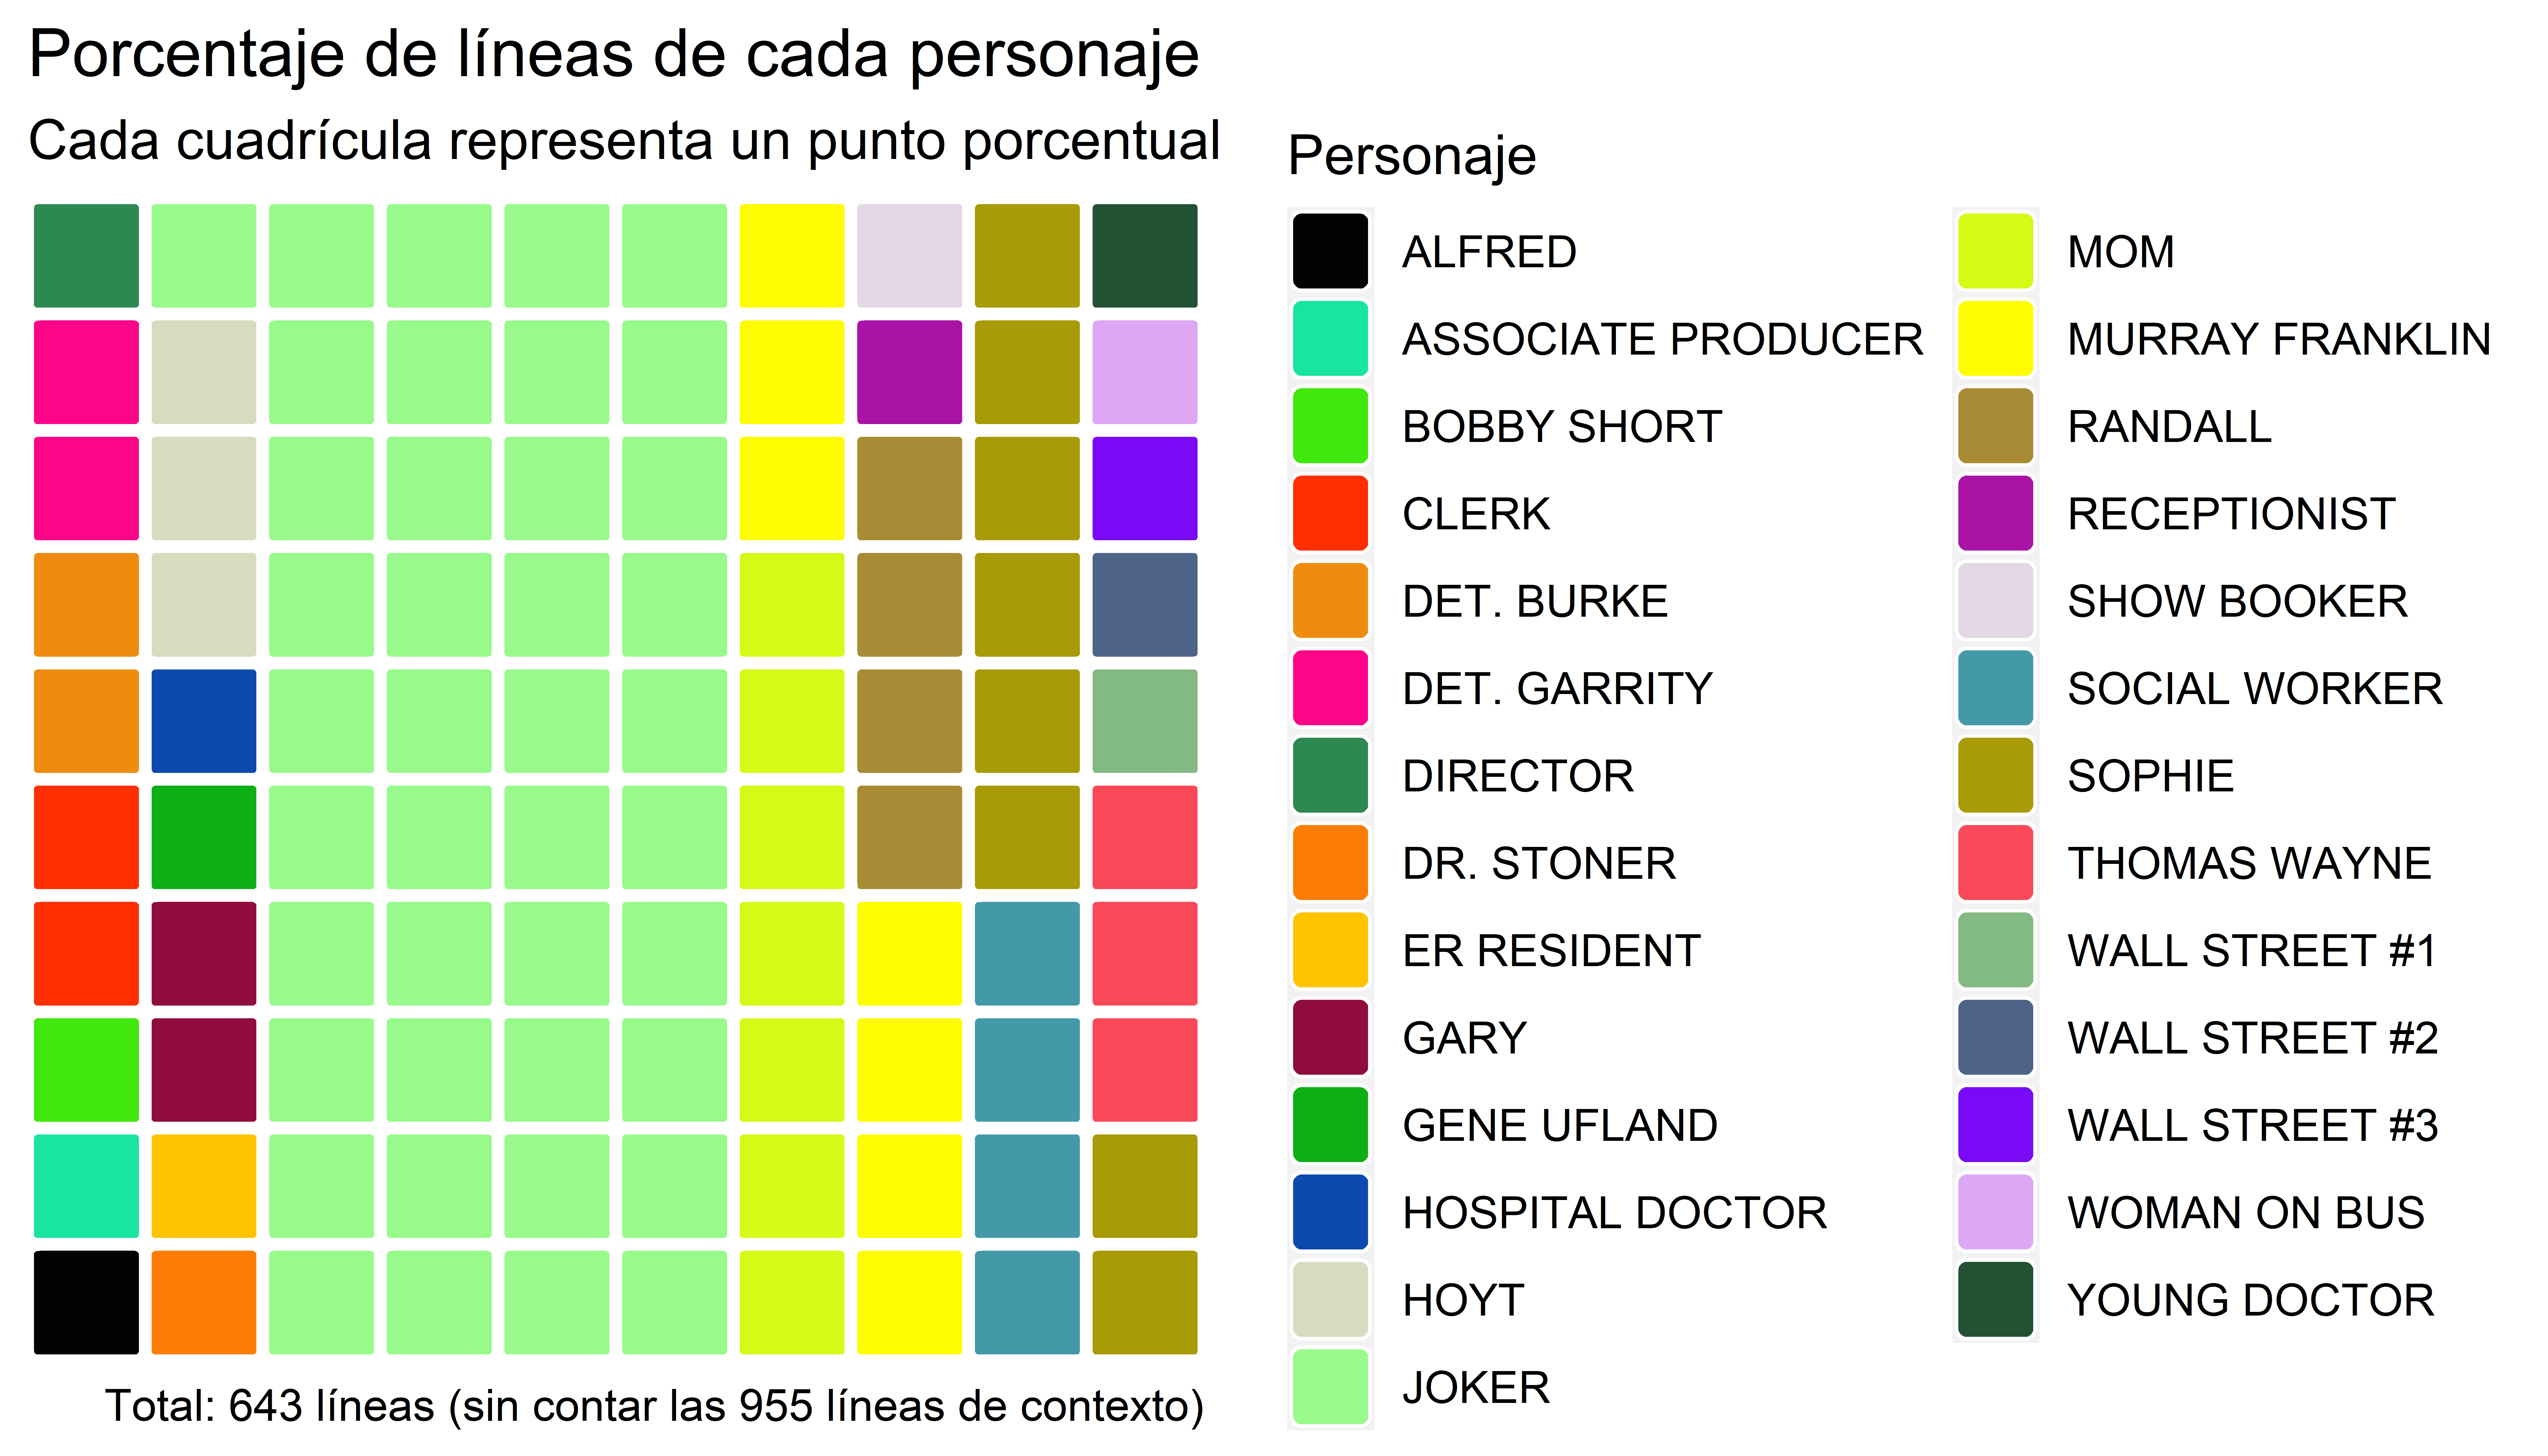

En total hay 47 personajes. **Gracias a este gráfico nos enteramos de que solo 27 personajes tienen —cada uno— al menos 1% de las líneas del guión.** Es decir, los 20 personajes restantes tienen —cada uno— muy pocas líneas.

Además, las "líneas" del personaje Bobby Short son en verdad extractos de la canción *Send in the Clowns*. Estas líneas están en el guión para enfatizar que el plan original era reproducir esa canción durante la escena en que el Joker enfrenta dentro del metro a los muchachos que trabajan en la empresa de Thomas Wayne.

&nbsp;

Ahora bien, no hay uniformidad en la cantidad de palabras que conforman a las líneas. Debido a ello, además de visualizar el porcentaje de líneas que corresponden a cada personaje deberíamos visualizar cuántas *palabras* corresponden a cada personaje. 

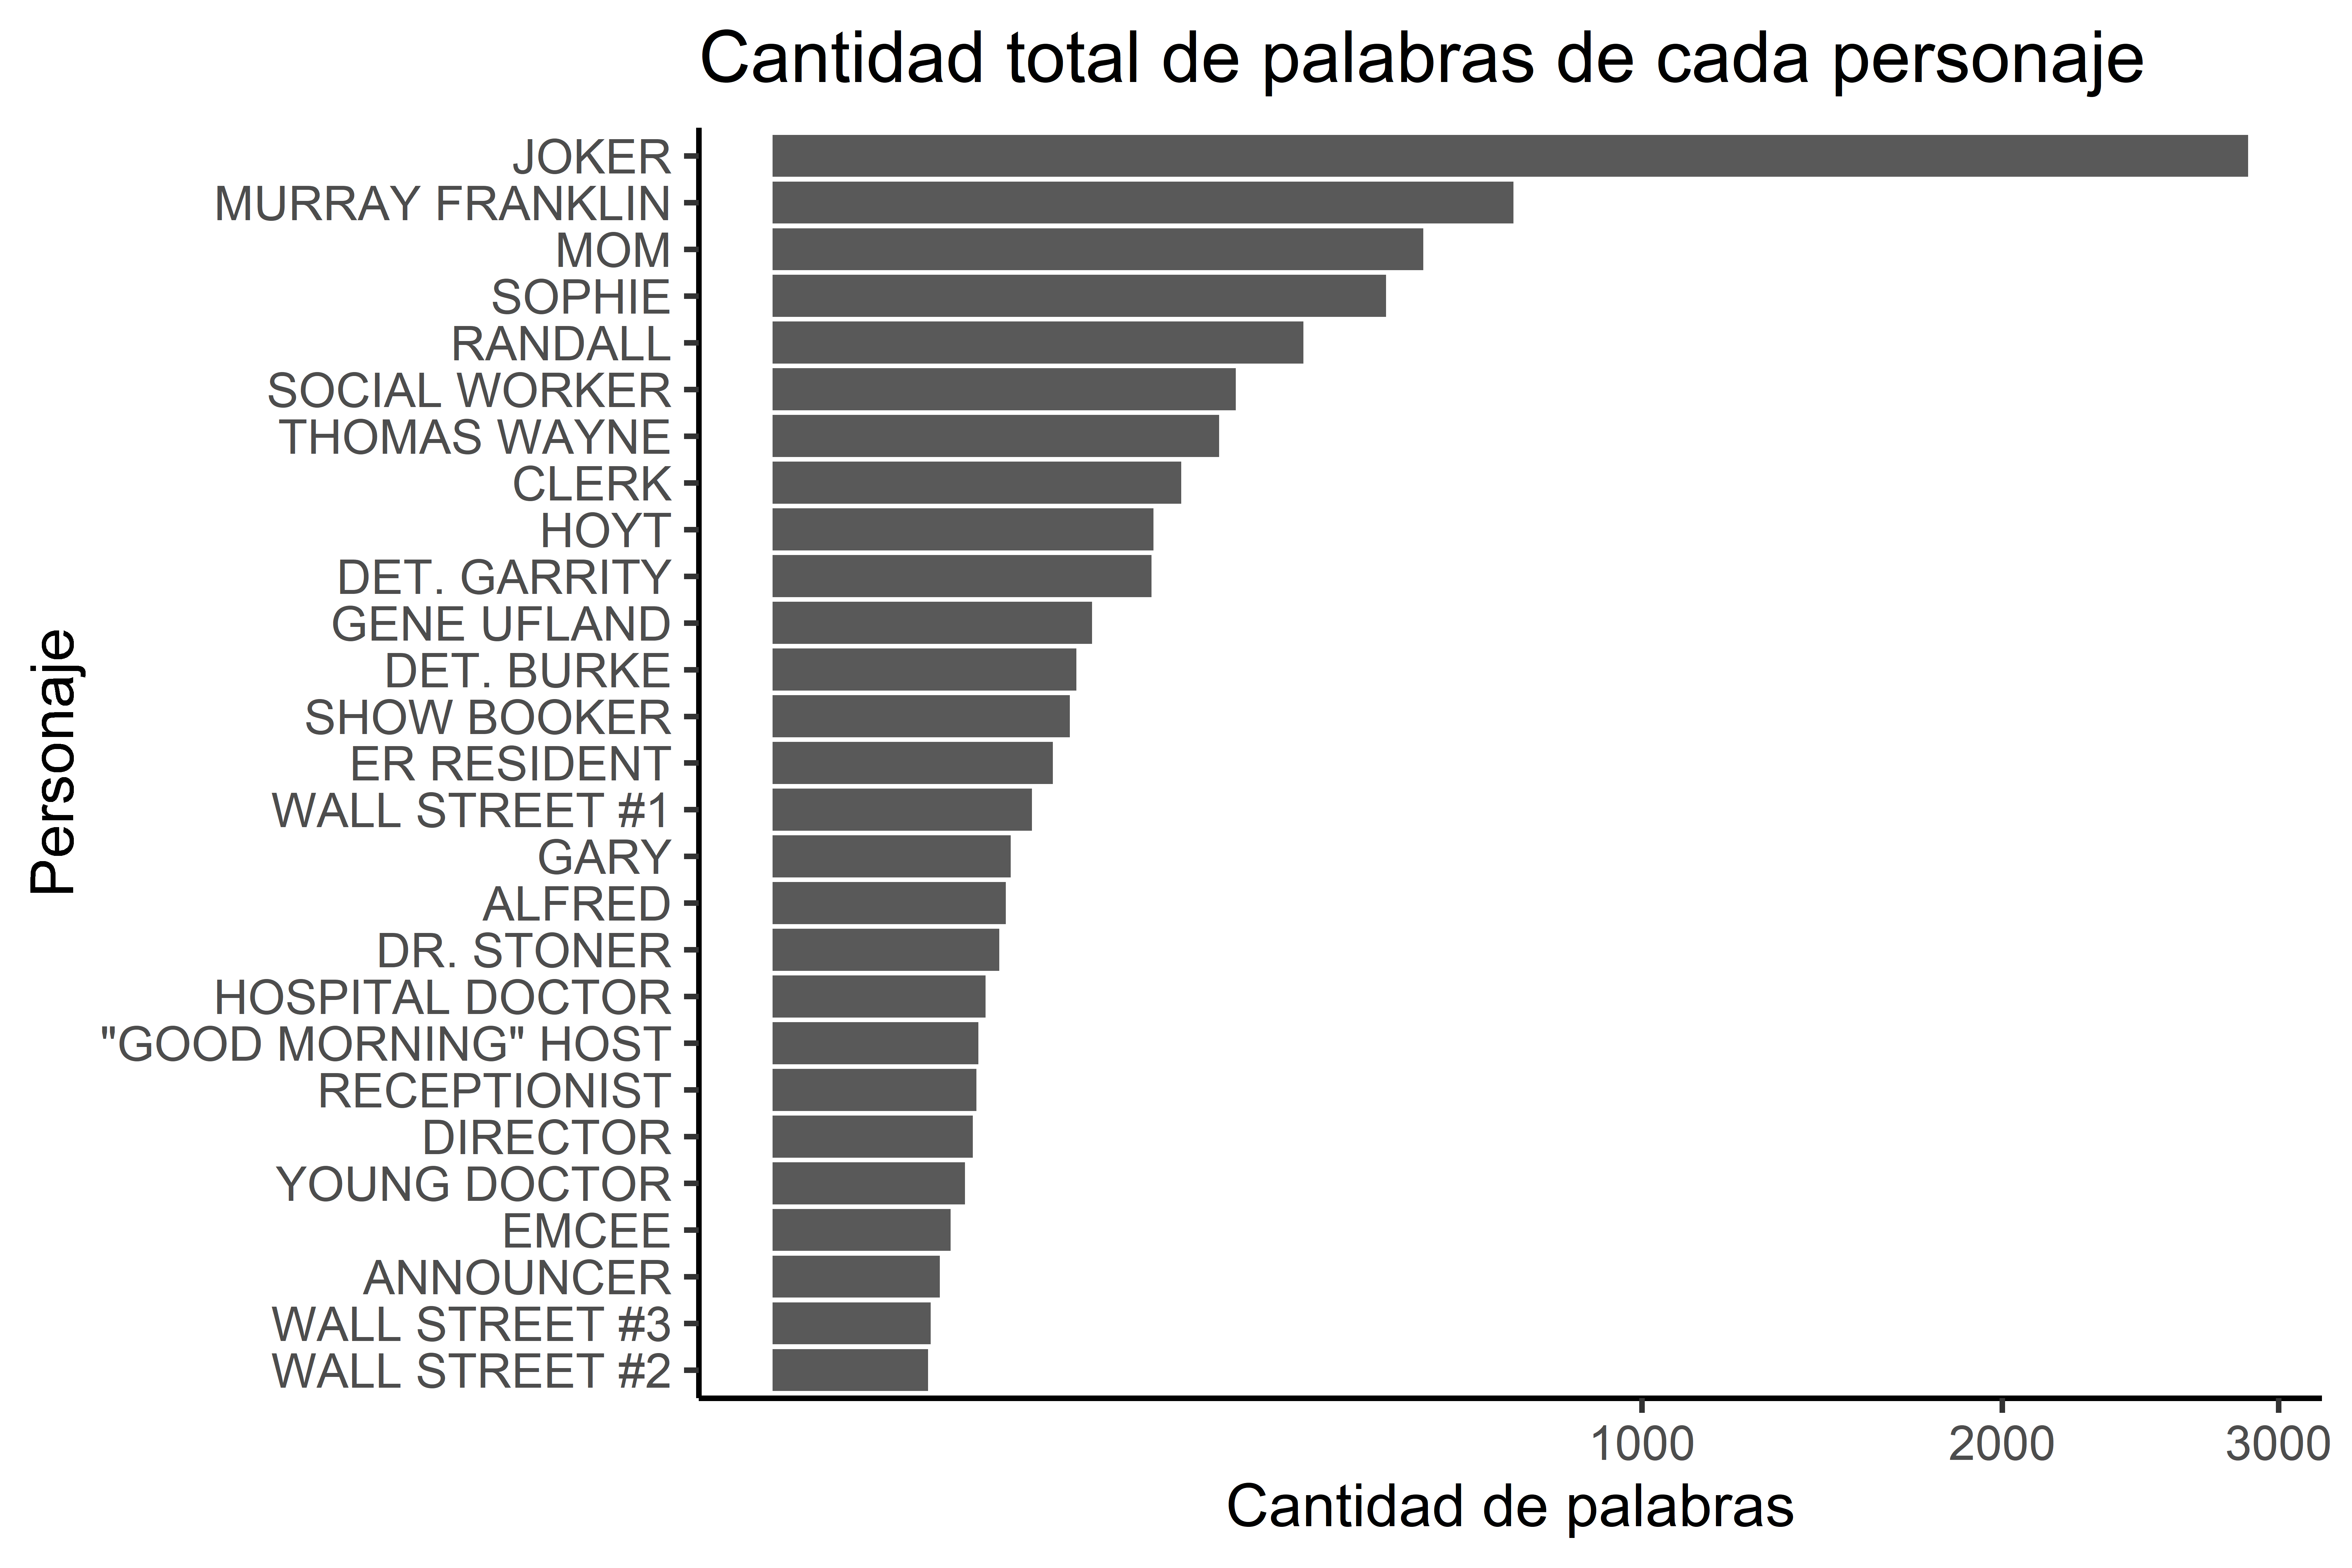

Se aprecia que el Joker es el único personaje que supera las mil palabras. De hecho, la cantidad de palabras que el guión asigna al Joker es 2881. El personaje que le sigue en términos de esta variable es Murray Franklin, con 726 palabras.

Para la mayoría de personajes tenemos muestras de texto pequeñas. **Esto no representa para nosotros un problema, pues nuestro proyecto consiste en entrenar un algoritmo en otro conjunto de documentos** —el cual sí es extenso— **y luego hacer predicciones en los documentos del guión del Joker utilizando aquel algoritmo.**

# Word clouds de los 7 personajes más prominentes (hechos en R)

## Joker

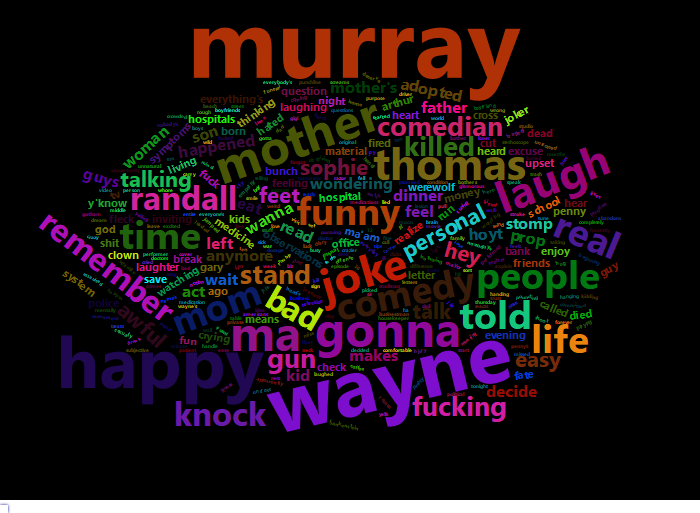

## Murray Franklin

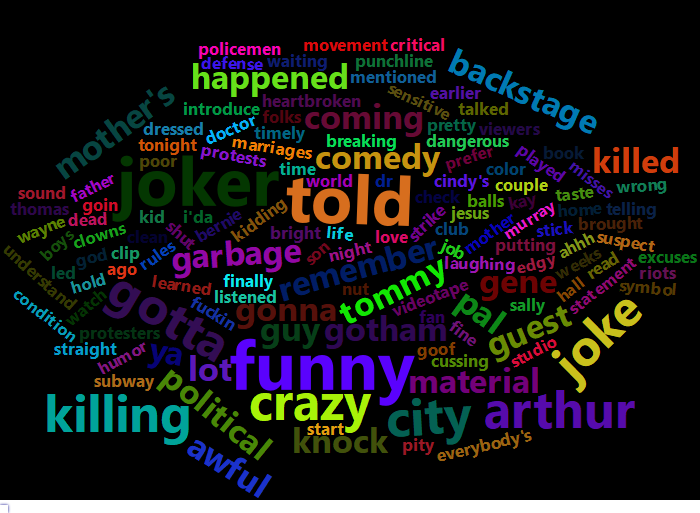

## Penny Fleck (mamá del Joker)

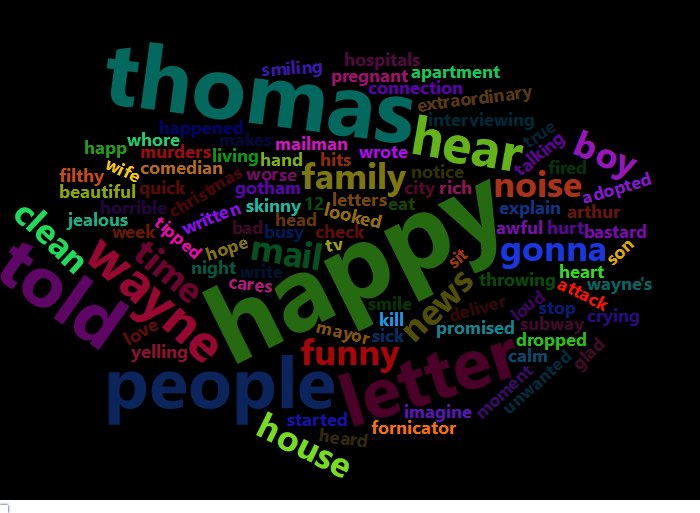

## Sophie

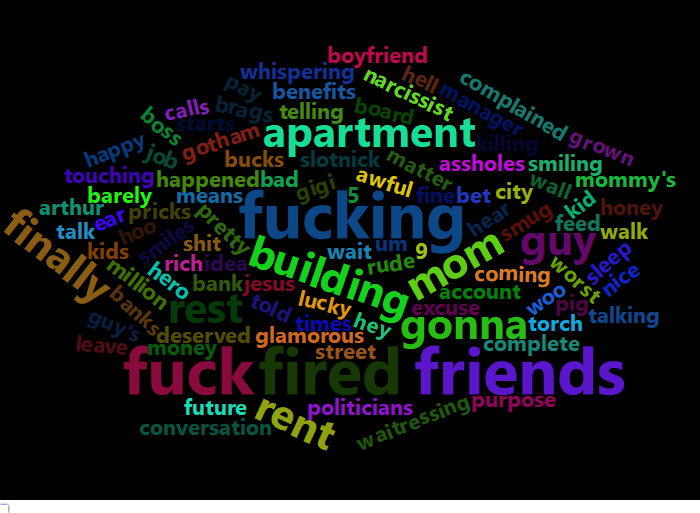

## Randall

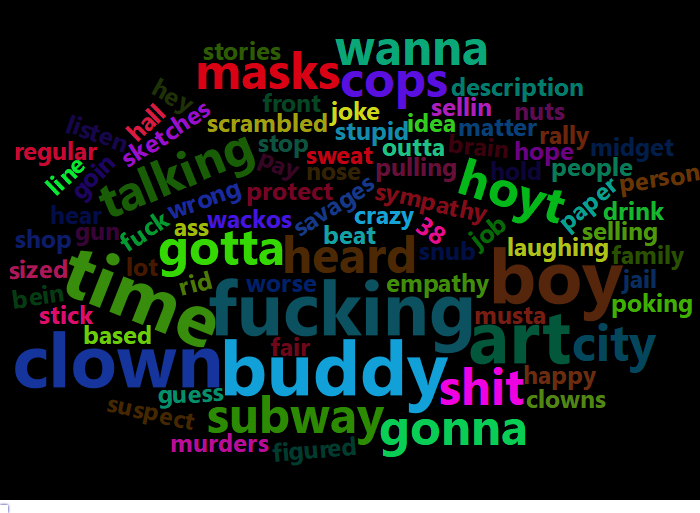

## La trabajadora social

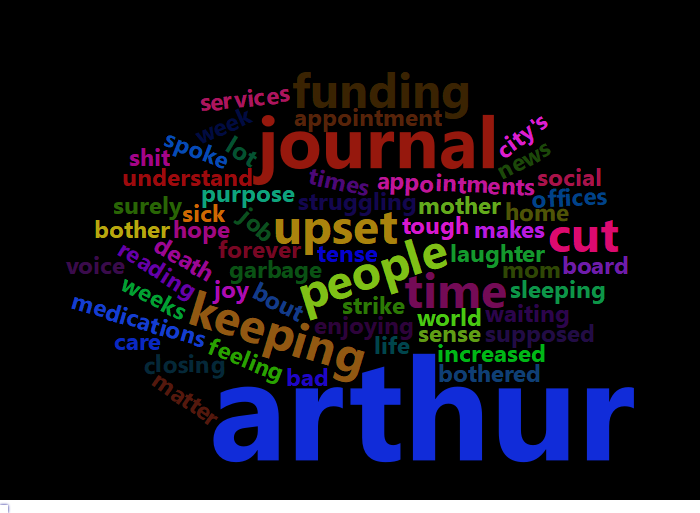

## Thomas Wayne

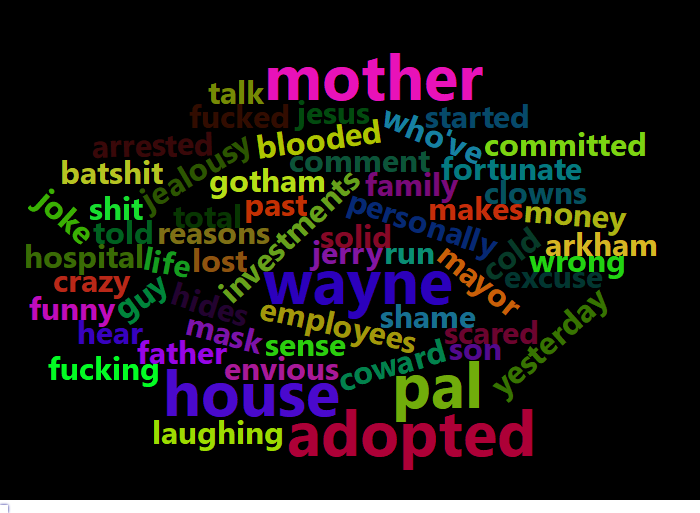

# Entrenamiento de clasificadores Myers-Briggs Type Indicator

## Background

El sistema de clasificación Myers-Briggs nace a partir del psicoanálisis junguiano como una sistematización de los arquetipos de personalidad que se contemplan en el quehacer clínico.

Este sistema plantea cuatro dimensiones binarias y ortogonales de la personalidad, **lo cual implica un total de 16 posibles tipos de personalidad.** Las dimensiones son

1.   extroversión (E) — introversión (I)
2.   sensación (S) — intuición (N)
3.   pensamiento (T) — sentimiento (F)
4.   juzgador (J) — perceptivo (P)

Por ejemplo, entonces, un individuo clasificado como ENFJ es extrovertido, intuitivo, sentimental y juzgador. Una más detallada descripción de este tipo de personalidad se puede hallar en [este enlace](https://www.16personalities.com/es/personalidad-enfj). Asimismo, para cada uno de los 16 arquetipos existe una descripción a detalle.

&nbsp;

**Nosotros vamos a hacer el ejercicio de inferir —a partir de sus respectivos diálogos— el arquetipo de cada uno de los personajes de la obra.** Nuestro proyecto podría ser de interés para la crítica literaria y la discusión de qué tan orgánicos o convincentes son los personajes creados por Todd Phillips y Scott Silver.

En una perspectiva más amplia, la capacidad de descifrar la personalidad de un individuo a partir del estilo de su discurso puede tener aplicaciones más prácticas. Por un lado —y esto puede ser de interés para *policy-makers*—, existe evidencia documentada de que [la personalidad permite predecir muchos aspectos de la vida de un individuo](https://pubmed.ncbi.nlm.nih.gov/16318601/), incluyendo su [nivel de ingreso](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5774615/). Por otro lado, para las áreas de recursos humanos de las empresas puede ser relevante aprovechar el historial de los posts que los postulantes a un puesto hacen en redes sociales para inferir —a partir de ellos— rasgos de la personalidad de los postulantes.



## Dataset

El dataset a ser usado para entrenar nuestros clasificadores consta de documentos etiquetados con el índice Myers-Briggs del correspondiente autor del documento. Son datos que [están disponibles en Kaggle](https://www.kaggle.com/datasnaek/mbti-type).

Hay dos maneras en que este ejercicio se podría enfocar. O bien como un problema de clasificación con 16 categorías, o bien como cuatro problemas de clasificación binaria. Nosotros optaremos por lo segundo. **Así, pues, entrenaremos un clasificador que sepa distinguir entre extroversión e introversión, uno que sepa distinguir entre sensación e intuición, otro que distinga entre pensamiento y sentimiento, y por último entrenaremos un clasificador que sepa distinguir entre juzgador y perceptivo.**

In [1]:
# Data Analysis
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse
from statistics import mean
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE



# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , StratifiedKFold, RandomizedSearchCV
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
### loading dataset
data_set = pd.read_csv("mbti_1.csv")
data_set.tail()

type                                              posts
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

# Exploratory data analysis

In [3]:
data_set.isnull().any()

type     False
posts    False
dtype: bool

In [4]:
nRow, nCol = data_set.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8675 rows and 2 columns


In [5]:
data_set.dtypes

type     object
posts    object
dtype: object

In [6]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [7]:
data_set.describe(include=['object'])

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'Oh yes, it's so fantastically true it's wonde...
freq    1832                                                  1

Hay 16 indicadores de tipo de personalidad únicos en el conjunto de datos

INFP es el tipo de personalidad que ocurre con más frecuencia en nuestro conjunto de datos

(no. de ocurrencias es 1832)

Por último, no hay publicaciones repetidas en el conjunto de datos

In [8]:
types = np.unique(np.array(data_set['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [9]:
total = data_set.groupby(['type']).count()*50
total

posts
type       
ENFJ   9500
ENFP  33750
ENTJ  11550
ENTP  34250
ESFJ   2100
ESFP   2400
ESTJ   1950
ESTP   4450
INFJ  73500
INFP  91600
INTJ  54550
INTP  65200
ISFJ   8300
ISFP  13550
ISTJ  10250
ISTP  16850

Text(0.5, 1.0, 'Total posts for each personality type')

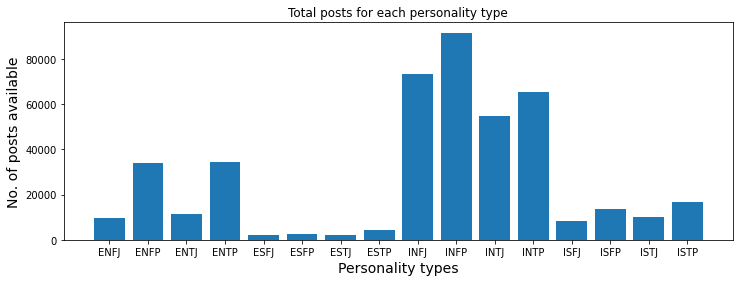

In [10]:
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

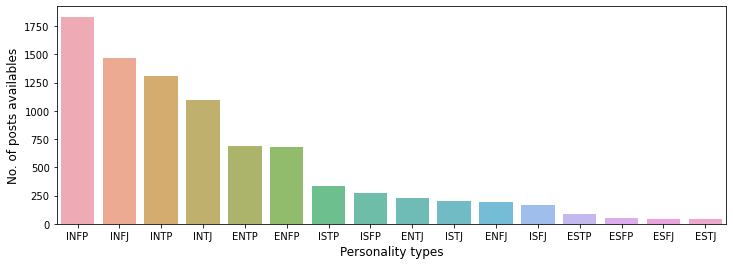

In [11]:
cnt_srs = data_set['type'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of posts availables', fontsize=12)
plt.show()

Dado que el conjunto de datos original solo venía con 2 características, el Tipo y 50 publicaciones para cada persona, decidimos crear características adicionales para explorar y analizar nuestro conjunto de datos.

**SWARM PLOT** :

<AxesSubplot:xlabel='type', ylabel='words_per_comment'>

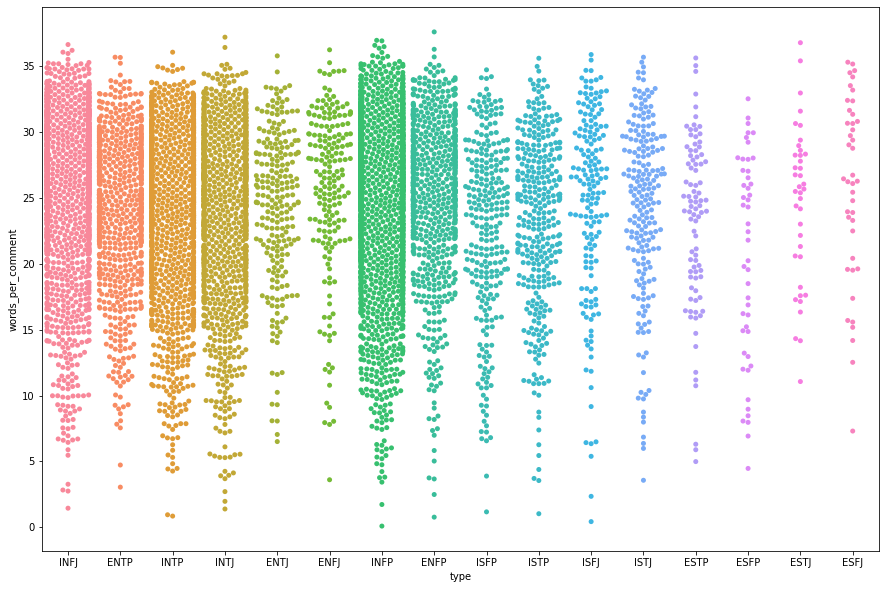

In [12]:
df = data_set.copy()
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sns.swarmplot("type", "words_per_comment", data=df)

La gráfica muestra el claro desequilibro que hay entre las clases.

**DISTANCE PLOT:**

Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

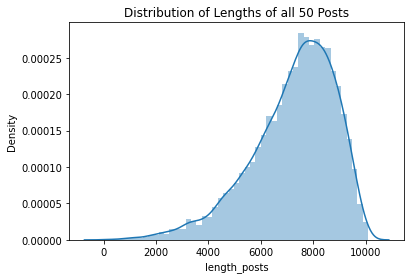

In [13]:
df["length_posts"] = df["posts"].apply(len)
sns.distplot(df["length_posts"]).set_title("Distribution of Lengths of all 50 Posts")

In [14]:
#Finding the most common words in all posts.
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546)]

**WORDCLOUD**

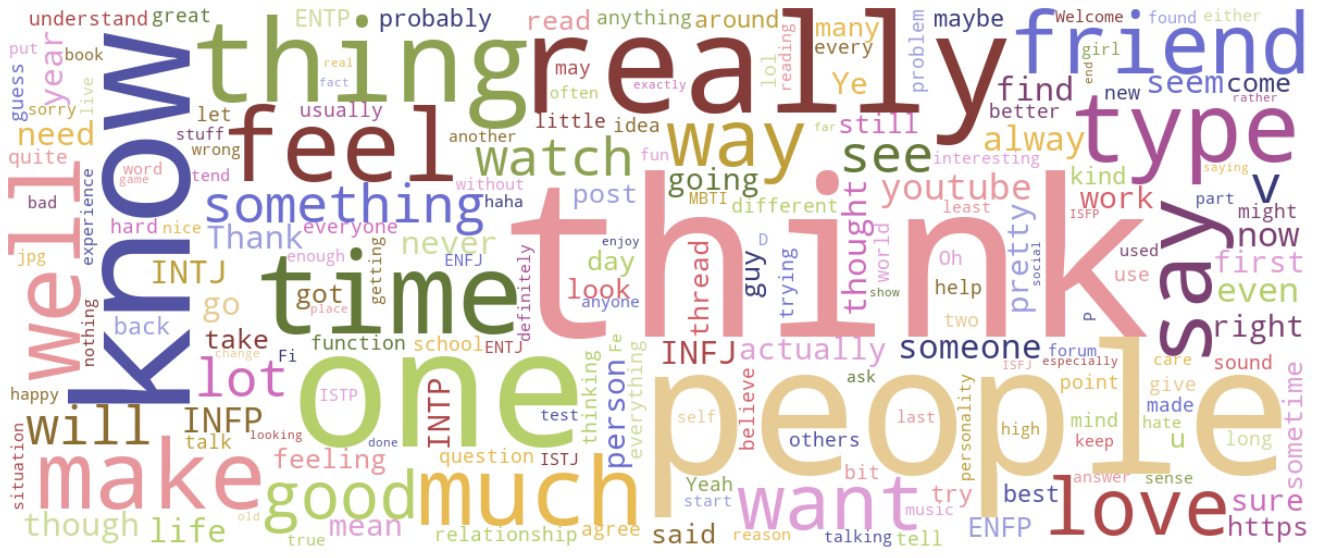

In [15]:
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

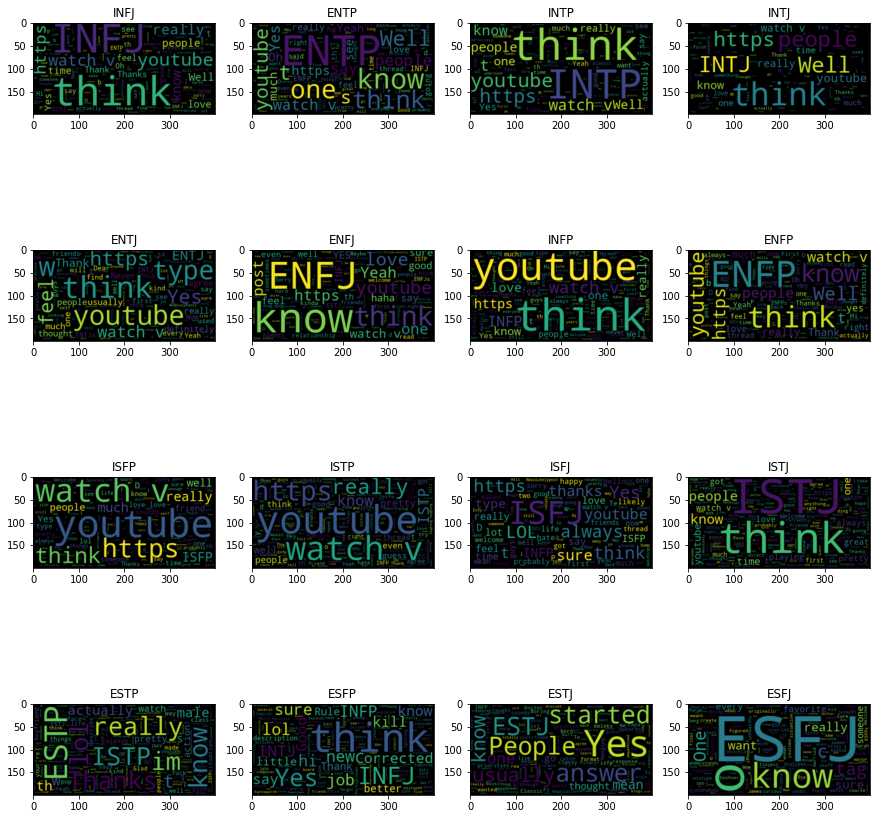

In [16]:
fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,len(df['type'].unique())))
k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

Podemos ver que hay un número de palabras irrelevantes presentes en el conjunto de datos (por ejemplo, ha, ar, Ti etx.) que deberán eliminarse Curiosamente, entre las palabras más comunes en el wordcloud, estan los tipos de personalidades como palabras.

Por lo tanto, sería necesario limpiar nuestras publicaciones eliminando estas palabras MBTI de cada una de ellas como parte de nuestra etapa de preprocesamiento, antes de entrenar el modelo para obtener mejores resultados de evaluación.‎

In [17]:
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))
print("5 posts:")
posts[0:5]

Number of users 8675
Number of posts 422845
5 posts:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]

Se observa que hay una gran cantidad de links, que no aportan ninguna informacion real sobre la pérsonalidad de la persona, por lo que tenemos que removerlo.

Recordar que los datos son de los comentarios de los usuarios de Kaggle. Con más datos podremos obtener mejores resultados

# Pre-Processing Stage

In [18]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words 
useless_words = stopwords.words("english")
# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

In [19]:
def preprocess_text(data, remove_stop_words=True, remove_mbti_profiles=True):
    list_posts = []
    len_data = len(data)
    i=0

    for row in data.iterrows():
      #Remove and clean comments
        posts = row[1].posts

        #Remove url links 
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

        #Remove Non-words - keep only words
        temp = re.sub("[^a-zA-Z]", " ", temp)

        # Remove spaces > 1
        temp = re.sub(' +', ' ', temp).lower()

        #Remove multiple letter repeating words
        temp = re.sub(r'([a-z])\1{2,}', r'\1\1', temp)
        temp = re.sub(r"\b(\w+)(?:\W\1\b)+", r"\1", temp)

        #Remove stop words
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        #Remove MBTI personality words from posts
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")


        # the cleaned data temp is passed here
        list_posts.append(temp)

      # returns the result
    list_posts = np.array(list_posts)
    return list_posts

posts_list = preprocess_text(data_set, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data_set.posts[0])
print("\nPost after preprocessing:\n\n", posts_list[0])

Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [20]:
new_df = data_set.copy()
new_df['posts_clean'] = posts_list
new_df

type                                              posts  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1     ENTP  'I'm finding the lack of me in these posts ver...   
2     INTP  'Good one  _____   https://www.youtube.com/wat...   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4     ENTJ  'You're fired.|||That's another silly misconce...   
...    ...                                                ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...   
8671  ENFP  'So...if this thread already exists someplace ...   
8672  INTP  'So many questions when i do these things.  I ...   
8673  INFP  'I am very conflicted right now when it comes ...   
8674  INFP  'It has been too long since I have been on per...   

                                            posts_clean  
0        moment sportscenter top ten play prank life...  
1      finding lack post alarming sex boring positio...  
2      good one course say know blessing curse absol...  
3      dear  enjoyed conversation day esoteric gabbi...  
4      fired another silly misconception approaching...  
...                                                 ...  
8670   ixfp always think cat fi doms reason especial...  
8671   thread already exists someplace else post hec...  
8672   many question thing would take purple pill pi...  
8673   conflicted right come wanting child honestly ...  
8674   long since personalitycafe although seem chan...  

[8675 rows x 3 columns]

## Splitting

In [21]:
enc = LabelEncoder()
new_df['type of encoding'] = enc.fit_transform(new_df['type'])

target = new_df['type of encoding'] 

In [22]:
new_df.head(15)

type                                              posts  \
0   INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1   ENTP  'I'm finding the lack of me in these posts ver...   
2   INTP  'Good one  _____   https://www.youtube.com/wat...   
3   INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4   ENTJ  'You're fired.|||That's another silly misconce...   
5   INTJ  '18/37 @.@|||Science  is not perfect. No scien...   
6   INFJ  'No, I can't draw on my own nails (haha). Thos...   
7   INTJ  'I tend to build up a collection of things on ...   
8   INFJ  I'm not sure, that's a good question. The dist...   
9   INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...   
10  INFJ  'One time my parents were fighting over my dad...   
11  ENFJ  'https://www.youtube.com/watch?v=PLAaiKvHvZs||...   
12  INFJ  'Joe santagato - ENTP|||ENFJ or  ENTP?   I'm n...   
13  INTJ  'Fair enough, if that's how you want to look a...   
14  INTP  'Basically this...  https://youtu.be/1pH5c1Jkh...   

                                          posts_clean  type of encoding  
0      moment sportscenter top ten play prank life...                 8  
1    finding lack post alarming sex boring positio...                 3  
2    good one course say know blessing curse absol...                11  
3    dear  enjoyed conversation day esoteric gabbi...                10  
4    fired another silly misconception approaching...                 2  
5    science perfect scientist claim scientific in...                10  
6    draw nail haha done professional nail yes gel...                 8  
7    tend build collection thing desktop use frequ...                10  
8   sure good question distinction two dependant p...                 8  
9    position actually let go person due various r...                11  
10   one time parent fighting dad affair dad pushe...                 8  
11   went break month ago together year planned li...                 0  
12   joe santagato    sure type yet know  heavy fi...                 8  
13   fair enough want look like stated incredibly ...                10  
14   basically cheezburgr fond top hat certainly e...                11

In [23]:
# Vectorizing the posts for the model and filtering Stop-words
vect = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 

train =  vect.fit_transform(new_df["posts_clean"])

In [24]:
train.shape

(8675, 791)

# Training & Evaluating

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6072, 791) (6072,) (2603, 791) (2603,)


In [26]:
accuracies = {}

In [27]:
#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# Prediction
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 26.93%


In [28]:
#Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

# Prediction
Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
accuracies['Random Forest'] = accuracy* 100.0 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 26.93%


In [29]:
#Gradient Descent
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)

Y_pred = sgd.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Gradient Descent'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 25.59%


In [30]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['Logistic Regression'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 30.35%


In [31]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X_train, y_train)

Y_pred = svm.predict(X_test)

predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracies['SVM'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 34.46%


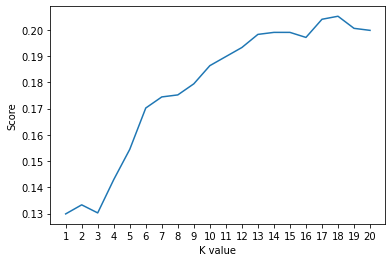

Maximum KNN 18
Maximum KNN Score is 20.51%


In [32]:
scoreList = []
for i in range(1,21):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,21), scoreList)
plt.xticks(np.arange(1,21,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

knn_max = scoreList.index(max(scoreList)) +1
print("Maximum KNN", knn_max)
accuracy = max(scoreList)
accuracies['KNN'] = accuracy* 100.0
print("Maximum KNN Score is {:.2f}%".format(accuracy*100))



## Comparing Algorithms

In [33]:
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

Accuracies(%)
Random Forest            26.930465
Gradient Descent         25.585862
Logistic Regression      30.349597
SVM                      34.460238
KNN                      20.514791

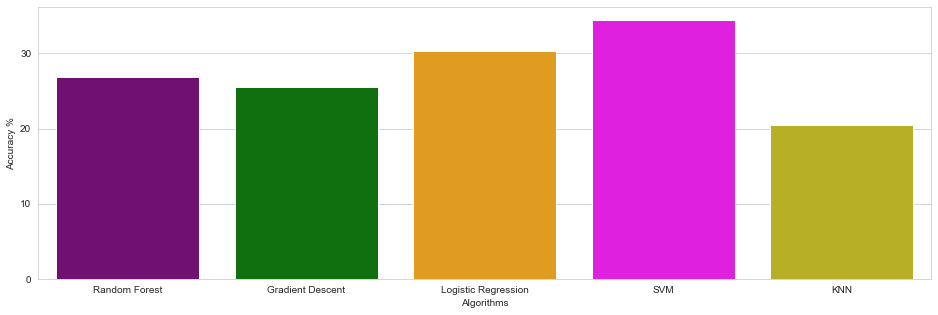

In [34]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

Como podemos ver , los clasificadores ml anteriores realiza un accuracy de casi 30% . Esto es bastante malo para un modelo ML. Por lo tanto, vamos cambiar la estrategia de modelamiento. En lugar de realizar un modelo para clasificar los 16 tipos de personalidades MBTI, ahora vamos a crear 4 modelos ML para los 4 ejes que contiene toda personalidad MBTI.

El indicador de tipo Myers Briggs (o MBTI para abreviar) es un sistema de tipo de personalidad que divide a todos en 16 tipos de personalidad distintos, en 4 ejes:

    Introversión (I) – Extroversión (E)
    Intuition (N) – Sensing (S)
    Thinking (T) – Feeling (F)
    Judging (J) – Perceiving (P)
Quiere decir que un tipo de personalidad MBTI contiene 4 ejes. Y cada eje contiene 2 variedades, por que lo podríamos realizar un modelamiento binario para cada eje.

# Four Classifiers across MBTI axis

In [35]:
data = pd.read_csv("mbti_1.csv")
data

type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]

Ahora vamos agregar columnas para indicar el tipo de personalidad

In [36]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

type                                              posts  IE  NS  TF  JP
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   1   1   0   1
1  ENTP  'I'm finding the lack of me in these posts ver...   0   1   1   0
2  INTP  'Good one  _____   https://www.youtube.com/wat...   1   1   1   0
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   1   1   1   1
4  ENTJ  'You're fired.|||That's another silly misconce...   0   1   1   1

In [37]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


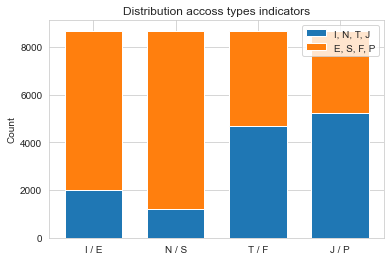

In [38]:
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, J")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

Observamos que hay una distribución desbalanceada, incluso entre cada uno de los 4 ejes en las entradas del conjunto de datos de salida, es decir en IE: E es la mayoría, en NS:S es la mayoría. Mientras que TF y JP tienen relativamente menos diferencia entre ellos.

In [39]:
data[['IE','NS','TF','JP']].corr()

IE        NS        TF        JP
IE  1.000000 -0.045899 -0.069573  0.161939
NS -0.045899  1.000000 -0.080954  0.014922
TF -0.069573 -0.080954  1.000000 -0.004673
JP  0.161939  0.014922 -0.004673  1.000000

<AxesSubplot:title={'center':'Features Correlation Heatmap'}>

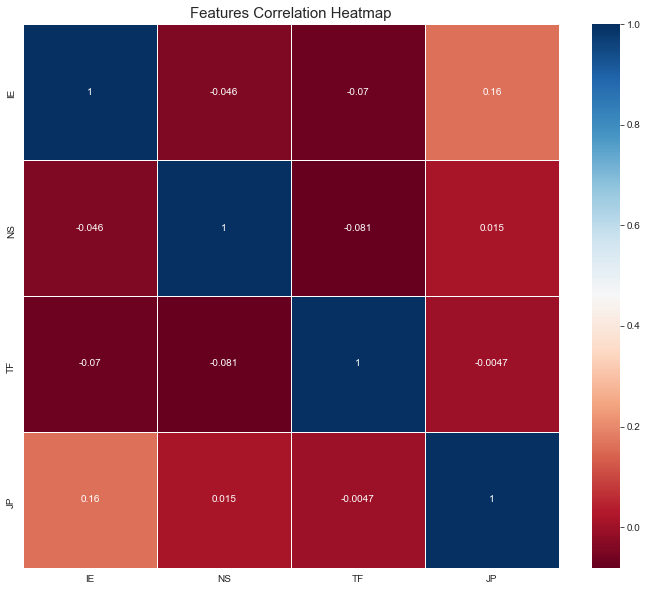

In [40]:
cmap = plt.cm.RdBu
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Features Correlation Heatmap', size=15)
sns.heatmap(corr, cmap=cmap,  annot=True, linewidths=1)

Observamos quee cada tipo de letra es independiente de otros tipos, es decir, la introversión / extroversión de una persona no está relacionada con su juicio / percepción.

## Pre-Processing Stage

In [41]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]


def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [42]:
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0

    for row in data.iterrows():
      #Remove and clean comments
        posts = row[1].posts

        #Remove url links 
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

        #Remove Non-words - keep only words
        temp = re.sub("[^a-zA-Z]", " ", temp)

        # Remove spaces > 1
        temp = re.sub(' +', ' ', temp).lower()

        #Remove multiple letter repeating words
        temp = re.sub(r'([a-z])\1{2,}', r'\1\1', temp)
        temp = re.sub(r"\b(\w+)(?:\W\1\b)+", r"\1", temp)

        #Remove stop words
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        #Remove MBTI personality words from posts
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        # transform mbti to binary vector
        type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        # the cleaned data temp is passed here
        list_posts.append(temp)

      # returns the result
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", list_posts[0])
print("\nMBTI before preprocessing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])

Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [43]:
nRow, nCol = list_personality.shape
print(f'No. of posts = {nRow}  and No. of Personalities = {nCol} ')

No. of posts = 8675  and No. of Personalities = 4 


## Feature Engineering

In [44]:
cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000,  
                             max_df=0.7,
                             min_df=0.1) 

# the feature should be made of word n-gram 
# Learn the vocabulary dictionary and return term-document matrix

print("Using CountVectorizer :")
X_cnt = cntizer.fit_transform(list_posts)

#The enumerate object yields pairs containing a count and a value (useful for obtaining an indexed list)
feature_names = list(enumerate(cntizer.get_feature_names()))
print("10 feature names can be seen below")
print(feature_names[0:10])

# For the Standardization or Feature Scaling Stage :-
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
print("\nUsing Tf-idf :")

print("Now the dataset size is as below")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()
print(X_tfidf.shape)

Using CountVectorizer :
10 feature names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'accept'), (4, 'accurate'), (5, 'across'), (6, 'act'), (7, 'action'), (8, 'actual'), (9, 'actually')]

Using Tf-idf :
Now the dataset size is as below
(8675, 791)


In [45]:
#counting top 10 words
reverse_dic = {}
for key in cntizer.vocabulary_:
    reverse_dic[cntizer.vocabulary_[key]] = key
top_10 = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0,-10:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_10]

['year',
 'actually',
 'work',
 'sure',
 'pretty',
 'yes',
 'mean',
 'feeling',
 'day',
 'take']

### Splitting into X and Y variable

In [46]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [47]:
print("X: FIRST posts in tf-idf representation\n%s" % X_tfidf[0])

X: FIRST posts in tf-idf representation
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.08042264 0.06830265 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.10331608 0.         0.04973439 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.10984659 0.         0.         0.         0.08642568
 0.         0.         0.1048902  0.         0.         0.
 0.         0.         0.05188922 0.06824783 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

In [48]:
print("For MBTI personality type : %s" % translate_back(list_personality[0,:]))
print("Y : Binarized MBTI 1st row: %s" % list_personality[0,:])

For MBTI personality type : INFJ
Y : Binarized MBTI 1st row: [0 0 0 0]


## Training & Evaluating Models

In [49]:
X = X_tfidf

In [50]:
accuracies = {}

In [51]:
def training_model (X, Y, model):
    accuracies = []
    for l in range(len(personality_type)):
    
        y = Y[:,l]

        skf = StratifiedKFold(n_splits=5)

        svc_accu_stratified = []

        for train_index, test_index in skf.split(X, y):

            x_train_fold, x_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            model.fit(x_train_fold, y_train_fold)

            y_pred = model.predict(x_test_fold)

            predictions = [round(value) for value in y_pred]

            svc_accu_stratified.append(accuracy_score(y_test_fold, predictions))
    
        accuracy = mean(svc_accu_stratified)
        accuracies.append(accuracy* 100.0)
        print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))
    return accuracies

In [52]:
rf = RandomForestClassifier()
accuracies['Random Forest'] = training_model(X, list_personality, rf)

IE: Introversion (I) / Extroversion (E) Accuracy: 76.96%
NS: Intuition (N) / Sensing (S) Accuracy: 86.19%
FT: Feeling (F) / Thinking (T) Accuracy: 71.12%
JP: Judging (J) / Perceiving (P) Accuracy: 62.51%


In [53]:
xgb = XGBClassifier(verbosity = 0)
accuracies['XG Boost'] = training_model(X, list_personality, xgb)

IE: Introversion (I) / Extroversion (E) Accuracy: 76.78%
NS: Intuition (N) / Sensing (S) Accuracy: 85.72%
FT: Feeling (F) / Thinking (T) Accuracy: 72.84%
JP: Judging (J) / Perceiving (P) Accuracy: 63.11%


In [54]:
xgb = XGBClassifier(verbosity = 0)
accuracies['XG Boost'] = training_model(X, list_personality, xgb)

IE: Introversion (I) / Extroversion (E) Accuracy: 76.78%
NS: Intuition (N) / Sensing (S) Accuracy: 85.72%
FT: Feeling (F) / Thinking (T) Accuracy: 72.84%
JP: Judging (J) / Perceiving (P) Accuracy: 63.11%


In [55]:
logreg = LogisticRegression()
accuracies['Logistic Regression'] = training_model(X, list_personality, logreg)

IE: Introversion (I) / Extroversion (E) Accuracy: 78.11%
NS: Intuition (N) / Sensing (S) Accuracy: 86.27%
FT: Feeling (F) / Thinking (T) Accuracy: 77.15%
JP: Judging (J) / Perceiving (P) Accuracy: 66.84%


In [56]:
knn = KNeighborsClassifier(n_neighbors = 20)
accuracies['KNN'] = training_model(X, list_personality, knn)

IE: Introversion (I) / Extroversion (E) Accuracy: 76.84%
NS: Intuition (N) / Sensing (S) Accuracy: 86.20%
FT: Feeling (F) / Thinking (T) Accuracy: 64.08%
JP: Judging (J) / Perceiving (P) Accuracy: 62.55%


In [57]:
svc = SVC(random_state = 1)
accuracies['SVM'] = training_model(X, list_personality, svc)

IE: Introversion (I) / Extroversion (E) Accuracy: 77.35%
NS: Intuition (N) / Sensing (S) Accuracy: 86.20%
FT: Feeling (F) / Thinking (T) Accuracy: 77.01%
JP: Judging (J) / Perceiving (P) Accuracy: 66.64%


In [58]:
accuracies_i = [accuracies[k][0] for k in accuracies.keys()]
accuracies_n = [accuracies[k][1] for k in accuracies.keys()]
accuracies_f = [accuracies[k][2] for k in accuracies.keys()]
accuracies_j = [accuracies[k][3] for k in accuracies.keys()]

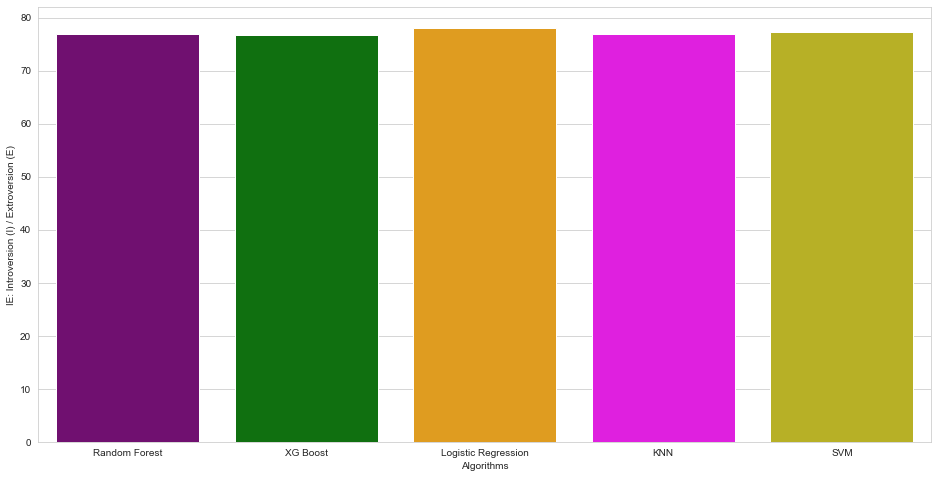

In [59]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]
sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
plt.yticks(np.arange(0,100,10))
plt.ylabel(personality_type[0])
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=accuracies_i , palette=colors)
plt.show()

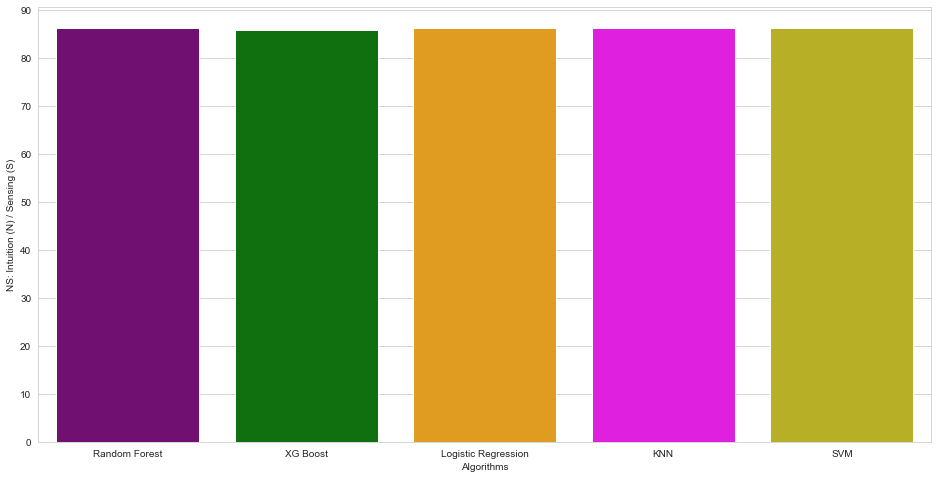

In [60]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
plt.yticks(np.arange(0,100,10))
plt.ylabel(personality_type[1])
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=accuracies_n , palette=colors)
plt.show()

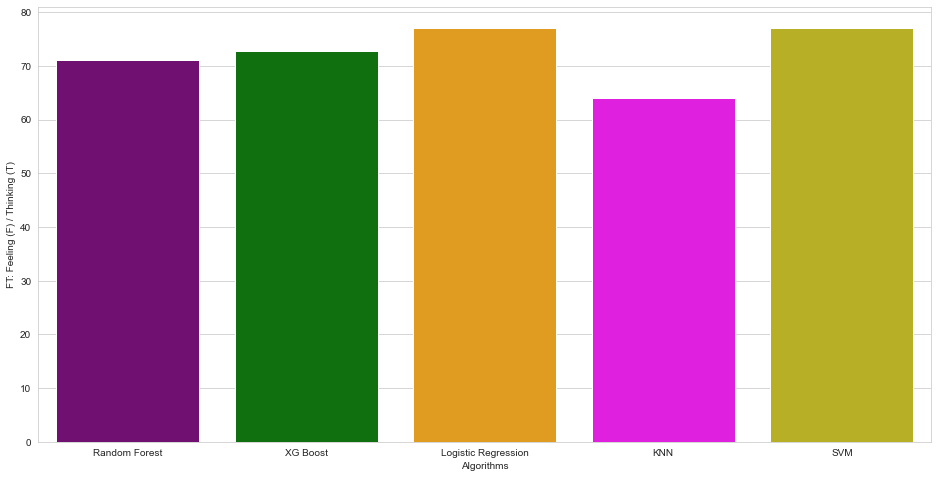

In [61]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
plt.yticks(np.arange(0,100,10))
plt.ylabel(personality_type[2])
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=accuracies_f , palette=colors)
plt.show()

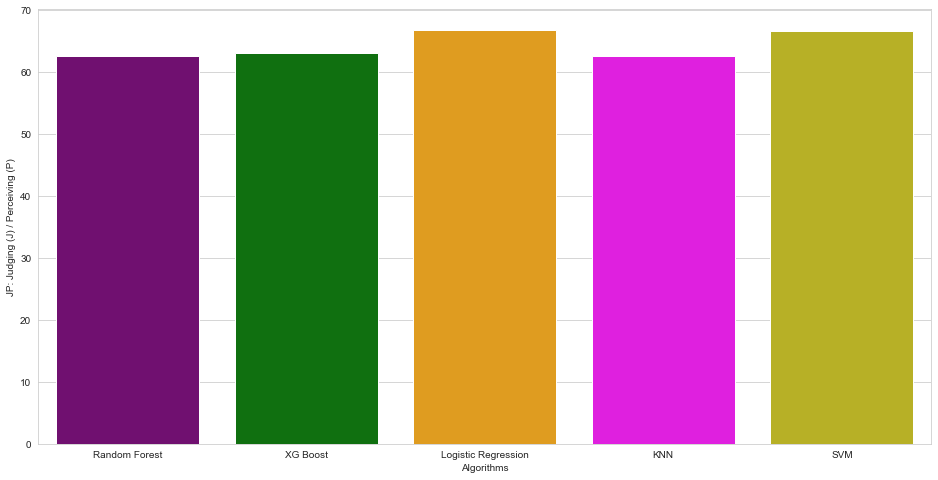

In [62]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
plt.yticks(np.arange(0,100,10))
plt.ylabel(personality_type[3])
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=accuracies_j , palette=colors)
plt.show()

Observamos que Logistic Regression es el modelo que mejor accuracy nos entrega, por lo cual lo usaremos para poder predecir la personalidad del script del Joker.

# Test Joker Movie Script

In [63]:
joker_movie = pd.read_csv('joker_script.csv')
joker_movie.head()

id                                           Line_raw  \
0  id0001  This story takes place in its own universe. It...   
1  id0002  We see it as a classic Warner Bros. movie. Gri...   
2  id0003  Although it is never mentioned in the film, th...   
3  id0004                                Let's call it 1981.   
4  id0005  It's a troubled time. The crime rate in Gotham...   

                                                Line Character_raw Character  \
0  This story takes place in its own universe. It...       CONTEXT   CONTEXT   
1  We see it as a classic Warner Bros. movie. Gri...       CONTEXT   CONTEXT   
2  Although it is never mentioned in the film, th...       CONTEXT   CONTEXT   
3                                Let's call it 1981.       CONTEXT   CONTEXT   
4  It's a troubled time. The crime rate in Gotham...       CONTEXT   CONTEXT   

        Setting  
0  INTRODUCTION  
1  INTRODUCTION  
2  INTRODUCTION  
3  INTRODUCTION  
4  INTRODUCTION

In [64]:
joker_movie.Character.unique()

array(['CONTEXT', 'JOKER', 'SOCIAL WORKER', 'KID #1', 'KID #2',
       'WOMAN ON BUS', 'SOPHIE', 'MOM', 'ANNOUNCER', 'RECEPTIONIST',
       'RANDALL', 'GARY', 'HOYT', 'BRANCH MANAGER', 'WALL STREET #1',
       'WALL STREET #2', 'WALL STREET #3', 'YOUNG WOMAN', 'BOBBY SHORT',
       'THOMAS WAYNE', '"GOOD MORNING" HOST', 'EMCEE', 'MURRAY FRANKLIN',
       'HA-HA CLOWN #1', 'HA-HA CLOWN #2', 'MAGICIAN', 'ALFRED',
       'DET. GARRITY', 'DET. BURKE', 'ER NURSE', 'ER RESIDENT',
       'YOUNG DOCTOR', 'NURSE #1', 'CLERK', 'DR. STONER',
       '"CLOWN" PROTESTER #1', '"CLOWN" PROTESTER #2', 'SHOW BOOKER',
       'GENE UFLAND', 'DR. SALLY FRIEDMAN', 'ASSOCIATE PRODUCER',
       'DIRECTOR', 'TECHNICAL DIRECTOR', 'POLICE LIEUTENANT',
       'POLICE OFFICER #1', 'POLICE OFFICER #2', 'PUNK',
       'HOSPITAL DOCTOR'], dtype=object)

In [65]:
def Character_Text(df, character):
    df = df.drop(['id','Line_raw', 'Character_raw','Setting'],1)
    df = df[df['Character']==character]
    df = df.reset_index(drop=True)
    text_joker = df.Line.to_list()
    text_joker = '|||'.join(text_joker)
    return df , text_joker

## Joker Character

In [66]:
joker_df, joker_text = Character_Text(joker_movie, 'JOKER')
joker_text

'--is it just me, or is it getting crazier out there?|||Yeah, I mean, it\'s different each day, so I really like that. I don\'t think I could ever work in an office. Behind a desk.|||No offense.|||Everyday.|||I\'m sorry. Did I bring what?|||Yes ma\'am.|||I\'ve been using it as a journal, but also a joke diary. Funny thoughts or, or observations-- Did I tell you I\'m pursuing a career in stand-up comedy?|||I think I did.|||Right.|||I didn\'t realize you wanted to read it.|||Yeah. I mean, that\'s just--|||No. I just,-- some of it\'s personal. You know?|||She has good days. But mostly bad. It\'s been a big help having me there. She really needs me.|||Yeah, it\'s good I\'m there. When I was in the hospital, after my last episode-- she was having trouble getting over there to visit.|||Yeah, I was wondering if you could ask the doctor to increase the dosage on my medications? Nothing seems to make a difference.|||Some.|||I just don\'t wanna feel so bad anymore.|||I wasn\'t bothering her, I w

In [67]:
my_posts  = joker_text

mydata = pd.DataFrame(data={'type': ['INFJ'], 'posts': [my_posts]})

my_posts, dummy  = pre_process_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = cntizer.transform(my_posts)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

In [68]:
result = []

for l in range(len(personality_type)):
    
    Y = list_personality[:,l]

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

    # fit model on training data
    model = logreg
    model.fit(X_train, y_train)
    
    # make predictions for my  data
    y_pred = model.predict(my_X_tfidf)
    result.append(y_pred[0])
    print("%s classifier trained" % (personality_type[l]))

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [69]:
print("The result is: ", translate_back(result))

The result is:  INFP
